In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# === CONFIGURATION ===
# Use your local file path (or the URL as backup)
IMAGE_PATH = r"C:\Users\LENOVO\Downloads\Lenna_(test_image).png"
# Fallback URL if local file has issues
# IMAGE_PATH = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"

# Target size (adjust based on your screen/speed)
IMAGE_SIZE = 512  # 512x512 pixels

# Compression levels to test
K_VALUES = [5, 20, 50, 100]


In [3]:
# === FUNCTIONS ===
def load_and_prepare(image_path, size=512):
    """Load image, convert to grayscale, and resize"""
    try:
        img = Image.open(image_path)
    except FileNotFoundError:
        print(f"❌ Local file not found: {image_path}")
        print("Trying URL fallback...")
        import requests
        from io import BytesIO
        response = requests.get("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png")
        img = Image.open(BytesIO(response.content))
    
    # Convert to grayscale
    img_gray = img.convert('L')
    
    # Resize to square
    img_gray = img_gray.resize((size, size), Image.Resampling.LANCZOS)
    
    return np.array(img_gray, dtype=np.float64)

def svd_reconstruct(image_matrix, k):
    """Reconstruct image using top k singular values"""
    U, S, Vt = np.linalg.svd(image_matrix, full_matrices=False)
    
    # Efficient reconstruction: U_k * diag(S_k) * Vt_k
    # Using broadcasting for memory efficiency
    reconstructed = U[:, :k] @ (S[:k, None] * Vt[:k, :])
    
    # Clip values to valid grayscale range
    reconstructed = np.clip(reconstructed, 0, 255)
    
    return reconstructed, S

def calculate_psnr(original, reconstructed):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def compression_ratio(m, n, k):
    """Calculate storage ratio: compressed / original"""
    original = m * n
    compressed = k * (m + n + 1)  # U: m*k, S: k, Vt: k*n
    return compressed / original

🔍 Loading Lenna image...
✅ Loaded: (512, 512) pixels, range: [25.0, 245.0]
⚡ Performing SVD decomposition...
✅ SVD complete. Top singular value: 64735.24
🎨 Reconstructing with k=5...
   → MSE: 716.41, PSNR: 19.58 dB, Compression: 0.020
🎨 Reconstructing with k=20...
   → MSE: 191.76, PSNR: 25.30 dB, Compression: 0.078
🎨 Reconstructing with k=50...
   → MSE: 62.37, PSNR: 30.18 dB, Compression: 0.196
🎨 Reconstructing with k=100...
   → MSE: 17.64, PSNR: 35.67 dB, Compression: 0.391

💾 Saved visualization to: lenna_svd_compression.png


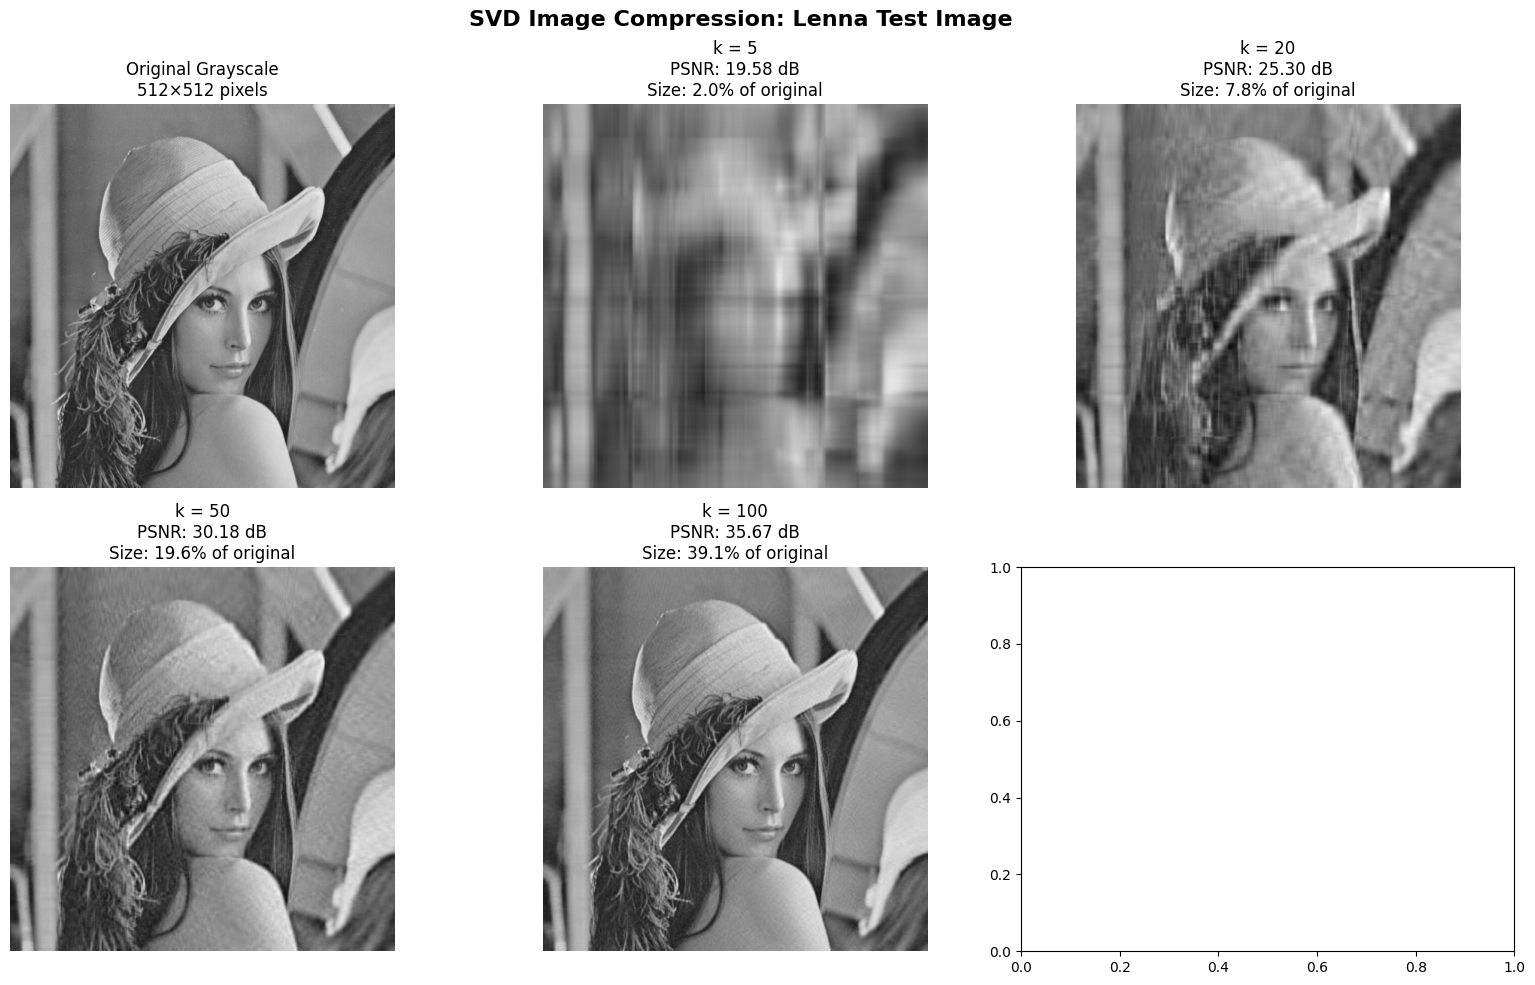


SUMMARY TABLE
    k |        MSE |    PSNR (dB) |   Size Ratio
------------------------------------------------------------
    5 |     716.41 |        19.58 |       0.020
   20 |     191.76 |        25.30 |       0.078
   50 |      62.37 |        30.18 |       0.196
  100 |      17.64 |        35.67 |       0.391

📊 Generating singular value decay plot...


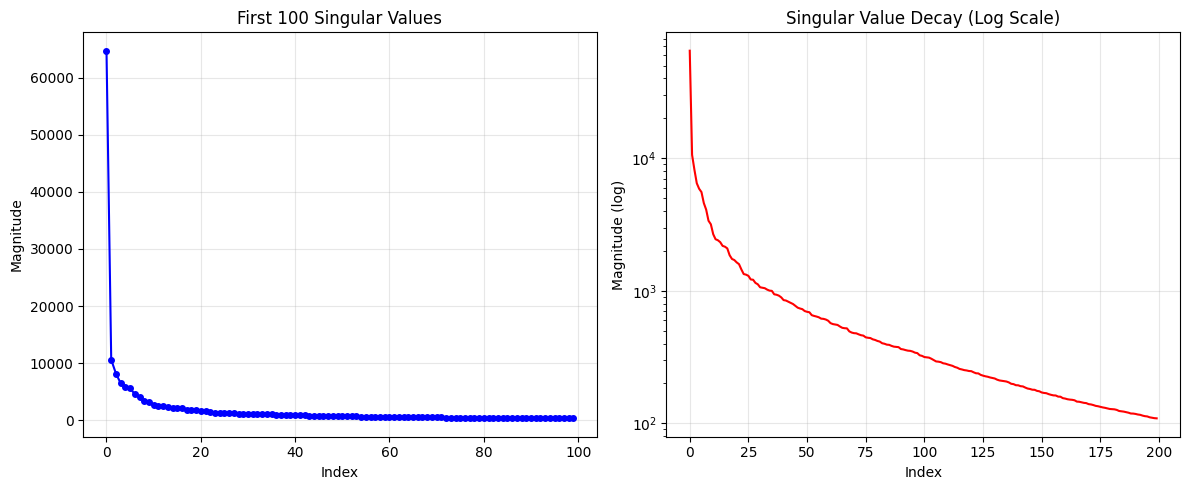

✅ All done! Check the saved PNG files in your working directory.


In [4]:
# === MAIN EXECUTION ===
if __name__ == "__main__":
    print("🔍 Loading Lenna image...")
    
    # Load image
    img_array = load_and_prepare(IMAGE_PATH, IMAGE_SIZE)
    print(f"✅ Loaded: {img_array.shape} pixels, range: [{img_array.min():.1f}, {img_array.max():.1f}]")
    
    # Perform SVD once
    print("⚡ Performing SVD decomposition...")
    U, S, Vt = np.linalg.svd(img_array, full_matrices=False)
    print(f"✅ SVD complete. Top singular value: {S[0]:.2f}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    # Plot original
    axes[0].imshow(img_array, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title(f"Original Grayscale\n{IMAGE_SIZE}×{IMAGE_SIZE} pixels")
    axes[0].axis('off')
    
    # Plot reconstructions
    results = []
    for idx, k in enumerate(K_VALUES, start=1):
        print(f"🎨 Reconstructing with k={k}...")
        
        # Reconstruct
        reconstructed, _ = svd_reconstruct(img_array, k)
        
        # Calculate metrics
        mse = np.mean((img_array - reconstructed) ** 2)
        psnr = calculate_psnr(img_array, reconstructed)
        ratio = compression_ratio(IMAGE_SIZE, IMAGE_SIZE, k)
        
        results.append({
            'k': k,
            'mse': mse,
            'psnr': psnr,
            'ratio': ratio
        })
        
        # Display
        axes[idx].imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
        axes[idx].set_title(f"k = {k}\n"
                           f"PSNR: {psnr:.2f} dB\n"
                           f"Size: {ratio:.1%} of original")
        axes[idx].axis('off')
        
        print(f"   → MSE: {mse:.2f}, PSNR: {psnr:.2f} dB, Compression: {ratio:.3f}")
    
    plt.suptitle('SVD Image Compression: Lenna Test Image', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save results
    output_file = 'lenna_svd_compression.png'
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    print(f"\n💾 Saved visualization to: {output_file}")
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*60)
    print("SUMMARY TABLE")
    print("="*60)
    print(f"{'k':>5} | {'MSE':>10} | {'PSNR (dB)':>12} | {'Size Ratio':>12}")
    print("-"*60)
    for r in results:
        print(f"{r['k']:5d} | {r['mse']:10.2f} | {r['psnr']:12.2f} | {r['ratio']:11.3f}")
    print("="*60)
    
    # Bonus: Singular value decay plot
    print("\n📊 Generating singular value decay plot...")
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(S[:100], 'bo-', markersize=4)
    plt.title('First 100 Singular Values')
    plt.xlabel('Index')
    plt.ylabel('Magnitude')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.semilogy(S[:200], 'r-', linewidth=1.5)
    plt.title('Singular Value Decay (Log Scale)')
    plt.xlabel('Index')
    plt.ylabel('Magnitude (log)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('lenna_singular_values.png', dpi=150)
    plt.show()
    
    print("✅ All done! Check the saved PNG files in your working directory.")
